<a href="https://colab.research.google.com/github/TheAnubisGod/Robotics/blob/main/Motor_modeling_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лабораторная работа №1 (Моделирование работы двигателя постоянного тока)



<h1>Выполнил: студент группы R3137 Дюжев Владислав Дмитриевич</h1>

## Цель

1. Познакомиться в оборудованием EV3 и различными средствами обработки данных.

2. Построить математическую модель ДПТ, изучить физические процессы.

3. Проанализировать функции $\theta(t)$ и $\omega(t)$.

##Создание математической модели


<p>Для начала займемся созданием математической модели работы ДПТ основываясь на базовых законах физики.</p>
<p>Введем обозначения: $M_{\Sigma}$ - суммарный момент; $M_{el}$ - момент электрических сил; $M_{oth}$ - момент внешних сил; $\varepsilon$ - ЭДС, возникающая в цепи якоря; $U$ - подаваемое напряжение; $\omega$ - угловая скорость; $J$ - момент инерции ротора; $k_e$ - конструктивная постоянная двигателя.</p>
<p>Согласно 2-му закону Ньютона для вращательного движения (в данном случае двигатель - ненагруженный, следовательно, $M_{oth}=0$):
$$\dot\omega J={M_\Sigma}=M_{el}+M_{oth}=M_{el}. \tag{1}$$</p>
<p>Согласно обобщенному закону Ома:
$$\varepsilon + U = IR. \tag{2}$$</p>
<p>Плечо на которое действует сила Ампера постоянно меняется, но мы будем использовать усредненую постоянную. Тогда можем записать:
$$M_{el} = {k_m}I. \tag{3}$$</p>
<p>ЭДС индукции:
$$\varepsilon_{i}=-\frac{d\Phi}{dt}=-{k_e}\omega. \tag{4}$$</p>
<p>Воспользовавшись приведенными выше формулами, запишем:
$$\dot\omega+\frac{k_m k_e}{JR}\omega=\frac{k_m}{JR}U. \tag{5}$$</p>
<p>Введем константу: $$T_m=\frac{JR}{k_e k_m}.\tag{6}$$</p>
<p>Запишем: $$ \dot\omega+\frac{\omega}{T_m}=\frac{U}{T_mk_e}. \tag{7} $$</p>
<p>Это уравнение с разделяющимися переменными: $$\frac{d\omega}{dt} = \frac{U-\omega k_e}{T_mk_e}$$</p>
<p>$$\frac{d\omega}{U-\omega k_e} = \frac{dt}{T_mk_e}.$$</p>
<p>Проинтегрируем:$$-\frac{\ln|U - \omega k_e|}{k_e} + C_1 = \frac{t}{T_mk_e}.$$</p>
<p>Домножим на $k_e$:$$-{\ln|U - \omega k_e|} + C_2 = \frac{t}{T_m}.$$</p>
<p>Воспользуемся тем фактом, что в начальный момент времни (t=0) $\omega(t) = 0$ $$C_2=\ln U$$</p>
<p>Подставим: $$\ln\frac{U-\omega k_e}{U} = -\frac{t}{T_m}$$</p>
<p>Тогда: $$\frac{U-\omega k_e}{U} = e^{-\frac{t}{T_m}}.$$</p>
<p>И, наконец: $$\omega(t) = \frac{U - U{e^{-\frac{t}{T_m}}}}{k_e}.\tag{8}$$</p>
<p>Проинтегрировав данную функцию: $$\theta(t) = \frac{U}{k_e}t+\frac{UT_me^{-\frac{t}{T_m}}}{k_e} + C.$$</p>
<p>При t=0, \theta(t)=0: $$C=-\frac{UT_m}{k_e}$$</p>
<p>Окончательно: $$\theta(t) = \frac{U}{k_e}t+\frac{UT_me^{-\frac{t}{T_m}}}{k_e} - \frac{UT_m}{k_e}.\tag{9}$$</p>

Воспользуемся модулем **sympy** для символьных вычислений, чтобы проверить правильность решения данного дифференциального уравнения.

In [48]:
import sympy
U, T_m, t = sympy.symbols("U, T_m, t") # Инициализируем обозначения
k_e = sympy.symbols("k_e", positive=True) 
omega = sympy.Function("omega")

In [49]:
diff_eq = sympy.Eq(omega(t).diff(t), U/(k_e*T_m) - omega(t)/T_m)
diff_eq

Eq(Derivative(omega(t), t), U/(T_m*k_e) - omega(t)/T_m)

В начальный момент (t=0) угловая скорость ($\omega$) равна 0.

In [50]:
diff_eq_sol = sympy.dsolve(diff_eq, omega(t), ics={omega(0):0}) # Решим уравнение
diff_eq_sol

Eq(omega(t), (U - U*exp(-t/T_m))/k_e)

Ответ совпадает с полученным в (8).

Получим выражения для угла $\theta(t)$.

In [51]:
theta = sympy.integrate(diff_eq_sol.rhs, (t,0,t)) # Проинтегрируем
theta

-T_m*U/k_e + T_m*U*exp(-t/T_m)/k_e + U*t/k_e

Ответ совпадает с полученным в (9).

## Работа с экспериментальными данными


<p>После построения математической модели движения двигателя можем сопоставить ее с данными, полученными при проведении эксперимента.</p>

Получим данные о зависимостях скорости и угла поворота двигателя от времени, запустив в EV3 следующий код:


```
#!/usr/bin/env python3
from ev3dev.ev3 import *
import time

# Инициализация мотора
motorA = LargeMotor('outA')
motorA.position = current_time = start_time = 0

speed = -100

# 10 измерений
while speed <= 100:
    # Обнуление угла
    motorA.position = 0
    # Пропуск цикла при скорости 0
    if speed == 0:
        speed += 10

    # Создание файла данных для определенной скорости и открытие его для записи
    fh = open("data(" + str(speed) + ").txt", "w")
    # Запись первой строки в файл
    fh.write("0" + " 0" + " 0" + "\n")
    # Начало отсчета времени
    start_time = time.time()

    # Получение и запись данных в файл
    try:
        while True:
            # Обновление счетчика времени
            current_time = time.time() - start_time
            # Через секунду прекращать
            if current_time > 3:
                break
            else:
                # Включение мотора на указанной скорости
                motorA.run_direct(duty_cycle_sp=speed)
                # Запись данных в файл
                fh.write(str(current_time) + " " + str(motorA.position) + " " + str(motorA.speed) + "\n")
    finally:
        # Остановка мотора
        motorA.stop(stop_action="brake")
        motorA.run_direct(duty_cycle_sp=0)
        # Ожидание и повышение скорости для следующей итерации
        time.sleep(2)
        speed += 10
        # Закрытие файла
        fh.close()

```



Для обработки и анализа данных будем использовать модули **pandas**, **numpy**, **matplotlib** и **scipy.optimize**.

In [52]:
# Импорт необходимых модулей
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [53]:
# импорт модуля для работы с файлам
from google.colab import files 
uploaded = files.upload()   

Saving data(20).txt to data(20) (1).txt
Saving data(-20).txt to data(-20) (1).txt
Saving data(40).txt to data(40) (1).txt
Saving data(-40).txt to data(-40) (1).txt
Saving data(60).txt to data(60) (1).txt
Saving data(-60).txt to data(-60) (1).txt
Saving data(80).txt to data(80) (1).txt
Saving data(-80).txt to data(-80) (1).txt
Saving data(100).txt to data(100) (1).txt
Saving data(-100).txt to data(-100) (1).txt


Получим массивы со значениями угла, скорости, времени для всех значений Voltage и переведем их в систему СИ:

In [54]:
time_all = []
angle_all = []
speed_all = []
for i in range(-100, 120, 20):
    if i == 0:
        continue
    data = (pd.read_csv(f"data({i}).txt", header=None, sep=" ")).to_numpy()
    time_all.append(data[:, 0])
    angle_all.append(data[:, 1] * np.pi / 180)
    speed_all.append(data[:, 2]/(180/np.pi))

График зависимости угла от времени (эксперимент):

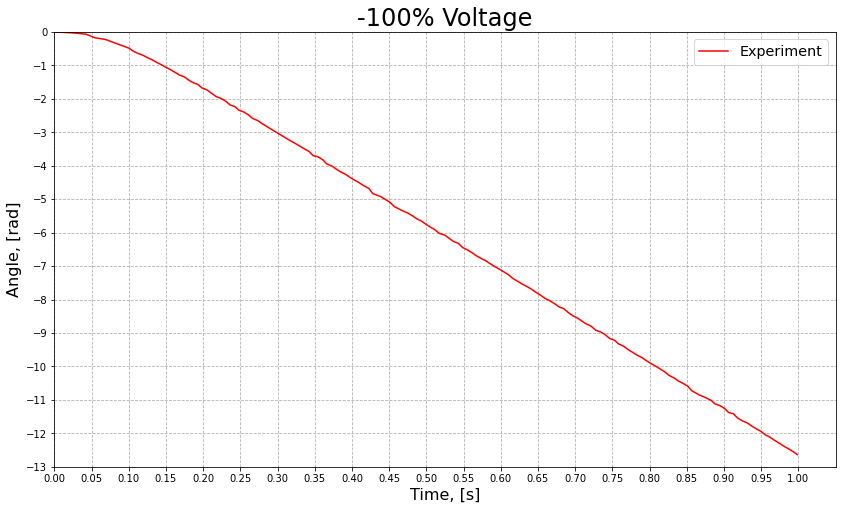

In [55]:
f, ax = plt.subplots(1, 1)
f.set_size_inches((14, 8))
ax.plot(time_all[0], angle_all[0], "r", markersize=6, linestyle="-", label="Experiment")
ax.set_xlabel("Time, [s]", size=16)
ax.set_ylabel("Angle, [rad]", size=16)
ax.set_title("-100% Voltage", size=24)
ax.set_xlim(0, 1.05)
plt.xticks([x / 100 for x in range(0, 105, 5)])
ax.grid(True, linestyle="--")
plt.yticks([x for x in range(-13, 1)])
ax.set_ylim(-13, 0)
legend = ax.legend(loc='upper right', fontsize='x-large')
legend.get_frame().set_facecolor('#FFFFFF')
f.show()

График зависимости скорости от времени (эксперимент):

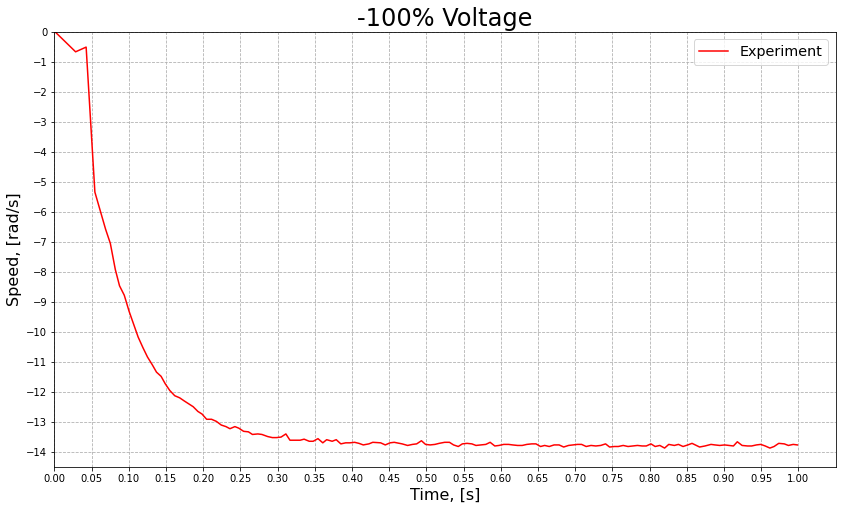

In [56]:
f, ax = plt.subplots(1, 1)
f.set_size_inches((14, 8))
ax.plot(time_all[0], speed_all[0], "r", linestyle="-", label="Experiment")
ax.set_xlabel("Time, [s]", size=16)
ax.set_ylabel("Speed, [rad/s]", size=16)
ax.set_title("-100% Voltage", size=24)
ax.set_xlim(0, 1.05)
plt.xticks([x / 100 for x in range(0, 105, 5)])
ax.grid(True, linestyle="--")
plt.yticks([x for x in range(-15,15)])
ax.set_ylim(-14.5, 0)
legend = ax.legend(loc='upper right', fontsize='x-large')
legend.get_frame().set_facecolor('#FFFFFF')
f.show()

Заметим, что физический смысл выражения $\frac{U}{k_e}$ представляет собой максимальную скорость вращения двигателя (обозначим ее $\omega_{nls}$).
На основе выражений (8) и (9) можем написать функции:

In [57]:
def angle(time, T_m, w_nls):
  return w_nls*time + w_nls*T_m*np.exp(-time/T_m) - w_nls*T_m

def speed(time, T_m, w_nls):
  return w_nls*(1 - np.exp(-time/T_m))

Воспользуемся функцией optimize.curve_fit для аппроксимации экспериментальных данных и получения значений параметров $T_m$ и $\omega_{nls}$ для каждого значения Voltage:

In [58]:
Tm_app_1 = []
Wm_app_1 = []
Tm_app_2 = []
Wm_app_2 = []
for j in range(10):
    time_data = time_all[j]
    angle_data = angle_all[j]
    speed_data = speed_all[j]
    p0 = [0.05,7]  
    # Аппроксимация данных об угле
    w, _ = opt.curve_fit(angle, time_data, angle_data, p0=p0) 
    Tm_app_1.append(w[0])
    Wm_app_1.append(w[1])
    # Аппроксимация данных о скорости                                    
    w, _ = opt.curve_fit(speed, time_data, speed_data, p0=p0) 
    Tm_app_2.append(w[0])
    Wm_app_2.append(w[1])

In [59]:
pd.DataFrame({'Voltage' : [-100, -80, -60, -40, -20, 20, 40, 60, 80, 100],'T_m (angle approximation)' : Tm_app_1,'T_m (speed approximation)' : Tm_app_2}).set_index("Voltage")

,T_m (angle approximation),T_m (speed approximation)
Voltage,,
-100,0.085135,0.090828
-80,0.068211,0.076292
-60,0.064371,0.074109
-40,0.064966,0.075920
-20,0.064622,0.076957
20,0.052628,0.070105
40,0.069087,0.080578
60,0.061775,0.073854
80,0.068031,0.075189


In [60]:
pd.DataFrame({'Voltage' : [-100, -80, -60, -40, -20, 20, 40, 60, 80, 100],'w_nls (angle approximation)' : Wm_app_1,'w_nls (speed approximation)' : Wm_app_2}).set_index("Voltage")

,w_nls (angle approximation),w_nls (speed approximation)
Voltage,,
-100,-13.838798,-13.867138
-80,-10.771259,-10.789293
-60,-7.958644,-7.975209
-40,-5.164897,-5.180731
-20,-2.361848,-2.364585
20,2.388694,2.391516
40,5.289099,5.304804
60,8.167221,8.188775
80,11.051364,11.063151


Построим графики функций угла и скорости от времени с учетом полученных параметров:

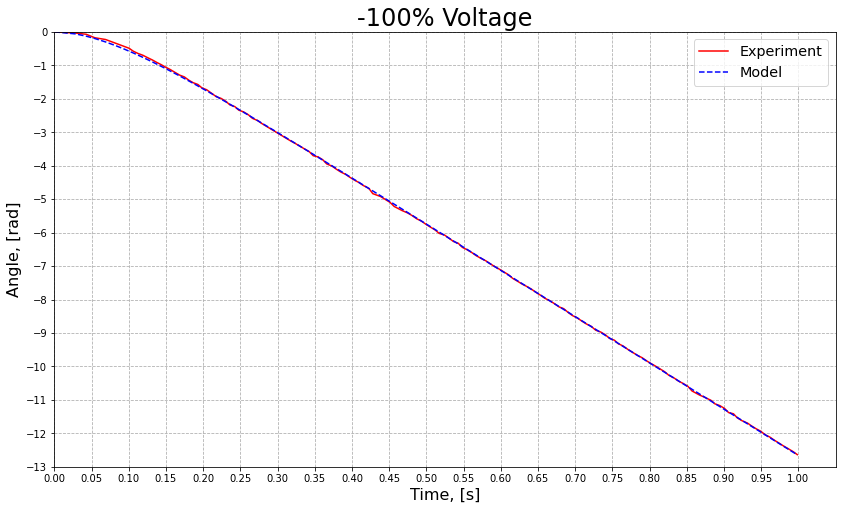

In [61]:
f, ax = plt.subplots(1, 1)
f.set_size_inches((14, 8))
ax.plot(time_all[0], angle_all[0], "r", linestyle="-", label="Experiment")
ax.plot(time_all[0], angle(time_all[0], Tm_app_1[0], Wm_app_1[0]), "b", linestyle="--", label="Model")
ax.set_xlabel("Time, [s]", size=16)
ax.set_ylabel("Angle, [rad]", size=16)
ax.set_title("-100% Voltage", size=24)
ax.set_xlim(0, 1.05)
plt.xticks([x / 100 for x in range(0, 105, 5)])
ax.grid(True, linestyle="--")
plt.yticks([x for x in range(-13, 1)])
ax.set_ylim(-13, 0)
legend = ax.legend(loc='upper right', fontsize='x-large')
legend.get_frame().set_facecolor('#FFFFFF')
f.show()

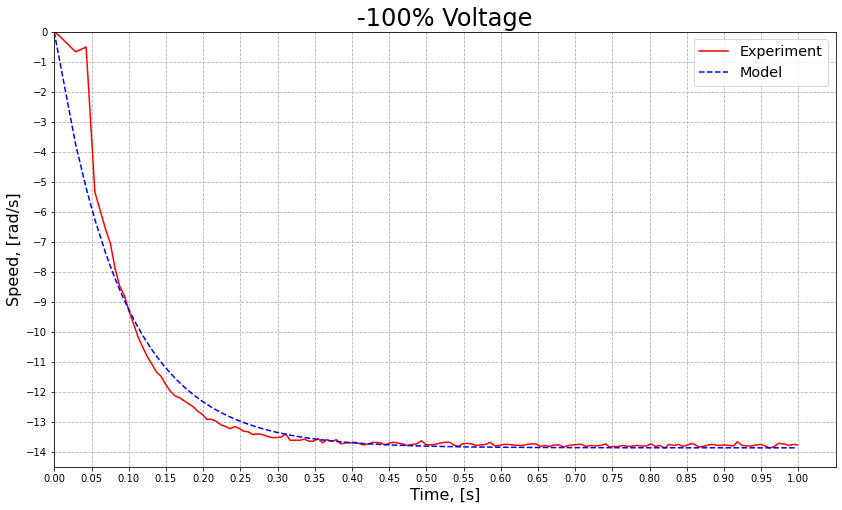

In [62]:
f, ax = plt.subplots(1, 1)
f.set_size_inches((14, 8))
ax.plot(time_all[0], speed_all[0], "r", linestyle="-", label="Experiment")
ax.plot(time_all[0], speed(time_all[0], Tm_app_2[0], Wm_app_2[0]), "b", linestyle="--", label="Model")
ax.set_xlabel("Time, [s]", size=16)
ax.set_ylabel("Speed, [rad/s]", size=16)
ax.set_title("-100% Voltage", size=24)
ax.set_xlim(0, 1.05)
plt.xticks([x / 100 for x in range(0, 105, 5)])
ax.grid(True, linestyle="--")
plt.yticks([x for x in range(-15,15)])
ax.set_ylim(-14.5, 0)
legend = ax.legend(loc='upper right', fontsize='x-large')
legend.get_frame().set_facecolor('#FFFFFF')
f.show()

Построим графики $T_m$ и $\omega_{nls}$ в зависимости от Voltage:

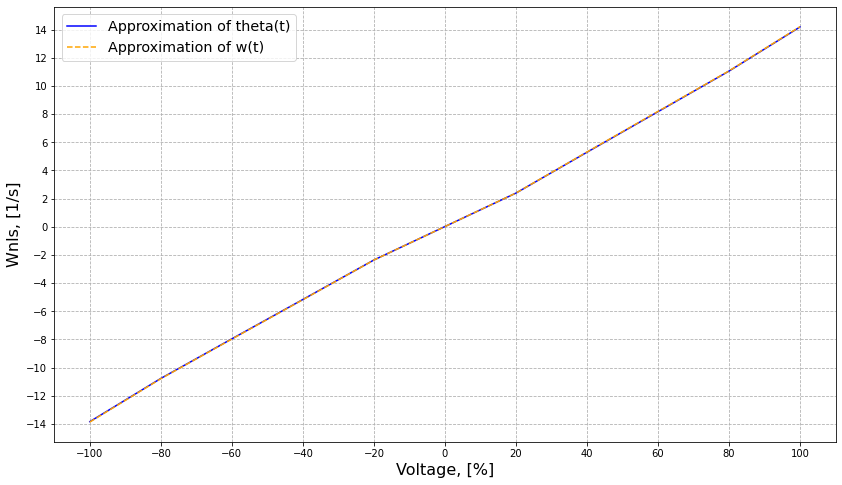

In [63]:
f, ax = plt.subplots(1, 1)
f.set_size_inches((14, 8))
ax.set_xlabel("Voltage, [%]", size=16)
ax.set_ylabel("Wnls, [1/s]", size=16)
ax.plot([-100, -80, -60, -40, -20, 20, 40, 60, 80, 100], Wm_app_1, color="blue",label="Approximation of theta(t)")
ax.plot([-100, -80, -60, -40, -20, 20, 40, 60, 80, 100], Wm_app_2, color="orange",label="Approximation of w(t)",linestyle="--")
plt.yticks([x for x in range(-14,16,2)])
plt.xticks([x for x in range(-100,120,20)])
plt.grid(True, linestyle="--")
legend = ax.legend(loc='upper left', fontsize='x-large')
legend.get_frame().set_facecolor('#FFFFFF')
f.show()

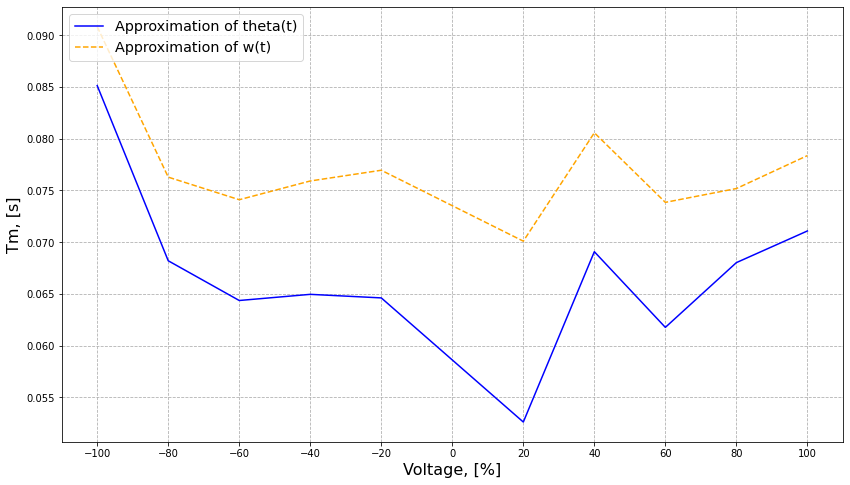

In [64]:
f, ax = plt.subplots(1, 1)
f.set_size_inches((14, 8))
ax.set_xlabel("Voltage, [%]", size=16)
ax.set_ylabel("Tm, [s]", size=16)
ax.plot([-100, -80, -60, -40, -20, 20, 40, 60, 80, 100], Tm_app_1, color="blue",label="Approximation of theta(t)")
ax.plot([-100, -80, -60, -40, -20, 20, 40, 60, 80, 100], Tm_app_2, color="orange",label="Approximation of w(t)",linestyle="--")
plt.grid(True, linestyle="--")
plt.xticks([x for x in range(-100,120,20)])
legend = ax.legend(loc='upper left', fontsize='x-large')
legend.get_frame().set_facecolor('#FFFFFF')
f.show()

## Выводы

1. В ходе выполнения работы мы познакомились с модулями matplotlib, pandas, scipy, sympy, numpy, упрощщающими такие задачи как построение математической модели физического процесса, анализ экспериментальных данных и сопоставление их с мат. моделью, построение графиков.

2. Используя фундаментальные законы физики мы смогли создать математическую модель (проверили полученных результат с помощью модуля scipy) ДПТ, которая достаточно точно описывает реальный процесс (как мы убедились после анализа экспериментальных данных). 

3. Стоит указать на некоторые недочеты и возможные улучшения точности модели.<br> Во-первых, при построении мат. модели мы не учитывали влияние внешних сил (например трения) и электродинамических процессов (в частности возникновение ЭДС индукции в обмотке якоря) на ротор. В подтверждение этого можно заметить, что график угла от времени, построенный на основании модели изначально растет/убывает (для отрицательнх значений) быстрее, нежели тот, что построен на основе экспериментальных данных. <br>
Во-вторых при аппроксимации функции угловой скорости от времени мы получаем достаточно большую ошибку (особенно при малых значениях t). Это связано с тем, что расчет угловой скорости EV3 производит недостаточно точно в начальные моментв движения. Возможным решением является удаление "лишних" данных об угловой скорости, повышающих ошибку модели.

4. Значения $T_m$ и $\omega_{nls}$ полученные в результате аппроксимации различных функций достаточно близки. Зная напряжение, подаваемое на двигатель, можно расчитать $k_e=\frac{U}{\omega_{nls}}$. Рассмотрев график $\omega_{nls}(U)$ заметим, что это - линейная зависимость, следовательно, $k_e=const$. Зависимость $T_m(U)$ является слишком сложной для описания.